https://www.cs.upc.edu/~erodri/webpage/cps/theory/lp/milp/slides.pdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import knapsack


def brute_force_knapsack(x_costs, x_times, x_satisfaction, x_budget, x_total_time):
    item_count = x_costs.shape[0]
    picks_space = 2 ** item_count
    best_satisfaction = -1
    best_picks = np.zeros(item_count)
    for p in range(picks_space):
        picks = [int(c) for c in f"{p:0{item_count}b}"]
        satisfaction = np.dot(x_satisfaction, picks)
        cost = np.dot(x_costs, picks)
        time = np.dot(x_times, picks)
        if cost <= x_budget and time <= x_total_time and satisfaction > best_satisfaction:
            best_satisfaction = satisfaction
            best_picks = picks
    return best_picks

'''
def fast_knapsack(x_weights, x_prices, x_capacity):
    best_price, best_picks = knapsack.knapsack(x_weights, x_prices).solve(x_capacity)
    return best_picks
'''

def create_knapsack(item_count=5):
    x_costs = np.random.randint(1, 45, item_count)
    x_times = np.random.randint(1, 45, item_count)
    x_satisfaction = np.random.randint(1, 99, item_count)
    x_budget = np.random.randint(1, 99)
    x_total_time = np.random.randint(1, 99)
    y = brute_force_knapsack(x_costs, x_times, x_satisfaction, x_budget, x_total_time)
    return x_costs, x_times, x_satisfaction, x_budget, x_total_time, y


def knapsack_loss(input_costs, input_time, input_satisfaction, cvc):
    def loss(y_true, y_pred):
        picks = y_pred
        violation_time = tf.keras.backend.maximum(tf.keras.backend.batch_dot(picks, input_time, 1) - 1, 0)
        violation_costs = tf.keras.backend.maximum(tf.keras.backend.batch_dot(picks, input_costs, 1) - 1, 0)
        satisfaction = tf.keras.backend.batch_dot(picks, input_satisfaction, 1)
        return cvc * violation_time + cvc * violation_costs - satisfaction

    return loss


def metric_oversatisfaction(input_satisfactions):
    def oversatisfaction(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.batch_dot(y_pred, input_satisfactions, 1) - tf.keras.backend.batch_dot(y_true, input_satisfactions, 1))

    return oversatisfaction


def metric_overcost(input_costs):
    def overcost(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.maximum(tf.keras.backend.batch_dot(y_pred, input_costs, 1) - 1, 0))

    return overcost

def metric_overtime(input_times):
    def overtime(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.maximum(tf.keras.backend.batch_dot(y_pred, input_times, 1) - 1, 0))

    return overtime


def metric_pick_count():
    def pick_count(y_true, y_pred):
        y_pred = tf.keras.backend.round(y_pred)
        return tf.keras.backend.mean(tf.keras.backend.sum(y_pred, -1))

    return pick_count


def unsupervised_model(cvc=5.75, item_count=5):
    input_costs = tf.keras.Input((item_count,), name="Costs")
    input_times = tf.keras.Input((item_count,), name="Times")
    input_satisfactions = tf.keras.Input((item_count,), name="Satisfactions")
    
    inputs_concat = tf.keras.layers.Concatenate(name="Concatenate")([input_costs, input_times, input_satisfactions])

    picks = tf.keras.layers.Dense(item_count ** 2 + item_count * 2, activation="sigmoid")(inputs_concat)
    picks = tf.keras.layers.Dense(item_count, activation="sigmoid")(picks)
    model = tf.keras.Model(inputs=[input_costs, input_times, input_satisfactions], outputs=[picks])
    model.compile("adam",
                  knapsack_loss(input_costs, input_times, input_satisfactions, cvc),
                  metrics=[tf.keras.metrics.binary_accuracy, metric_overcost(input_costs), metric_overtime(input_times),
                           metric_oversatisfaction(input_satisfactions), metric_pick_count()])
    return model


def supervised_model(item_count=5):
    
    input_costs = tf.keras.Input((item_count,), name="Costs")
    input_times = tf.keras.Input((item_count,), name="Times")
    input_satisfactions = tf.keras.Input((item_count,), name="Satisfactions")
    
    inputs_concat = tf.keras.layers.Concatenate(name="Concatenate")([input_costs, input_times, input_satisfactions])

    picks = tf.keras.layers.Dense(item_count ** 2 + item_count * 2, activation="sigmoid", name="Hidden")(inputs_concat)
    picks = tf.keras.layers.Dense(item_count, activation="sigmoid", name="Output")(picks)
    model = tf.keras.Model(inputs=[input_costs, input_times, input_satisfactions], outputs=[picks])
    
    
    model.compile("adam",
                  tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.binary_accuracy, metric_overcost(input_costs), metric_overtime(input_times),
                           metric_oversatisfaction(input_satisfactions), metric_pick_count()])
    return model


def create_knapsack_dataset(count, item_count):
    x1 = []
    x2 = []
    x3 = []
    y = []
    x_row = []
    for _ in range(count):
        x_costs, x_times, x_satisfaction, x_budget, x_total_time, answer = create_knapsack(item_count)
        x1.append(x_costs / x_budget)
        x2.append(x_times / x_total_time)
        x3.append(x_satisfaction / x_satisfaction.max())
        
        y.append(answer)

    return [np.array(x1), np.array(x2), np.array(x3)], np.array(y)


def train_knapsack(model, train_x, train_y, test_x, test_y, epochs=512):
    if os.path.exists("best_model.h5"): os.remove("best_model.h5")
    history = model.fit(train_x, train_y, epochs=epochs, verbose=1,
              callbacks=[
                  tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="binary_accuracy", save_best_only=True,
                                                     save_weights_only=True)])
    model.load_weights("best_model.h5")
    train_results = model.evaluate(train_x, train_y, 64, 0)
    test_results = model.evaluate(test_x, test_y, 64, 0)
    print("Model results(Train/Test):")
    print(f"Loss:               {train_results[0]:.2f} / {test_results[0]:.2f}")
    print(f"Binary accuracy:    {train_results[1]:.2f} / {test_results[1]:.2f}")
    print(f"Cost violation:    {train_results[2]:.2f} / {test_results[2]:.2f}")
    print(f"Time violation:    {train_results[3]:.2f} / {test_results[3]:.2f}")
    print(f"Oversatisfaction:        {train_results[4]:.2f} / {test_results[4]:.2f}")
    print(f"Pick count:         {train_results[5]:.2f} / {test_results[5]:.2f}")

    return history

tf.compat.v1.disable_eager_execution()
'''
if __name__ == "__main__":
    tf.compat.v1.disable_eager_execution()
    train_x, train_y = create_knapsack_dataset(10000)
    test_x, test_y = create_knapsack_dataset(200)
    model = supervised_model()
    train_knapsack(model, train_x, train_y, test_x, test_y)
    model = unsupervised_model()
    train_knapsack(model, train_x, train_y, test_x, test_y)
'''

'\nif __name__ == "__main__":\n    tf.compat.v1.disable_eager_execution()\n    train_x, train_y = create_knapsack_dataset(10000)\n    test_x, test_y = create_knapsack_dataset(200)\n    model = supervised_model()\n    train_knapsack(model, train_x, train_y, test_x, test_y)\n    model = unsupervised_model()\n    train_knapsack(model, train_x, train_y, test_x, test_y)\n'

# Case 1 - Academic

## Preparacion de la red neuronal

### Modo Supervisado

In [ ]:
train_x, train_y = create_knapsack_dataset(10000, item_count = 7)
test_x, test_y = create_knapsack_dataset(200, item_count = 7)

print(train_x[:5])
#print(train_x.shape)
print(train_y[:5])
print(train_y.shape)

print(test_x[:5])
#print(test_x.shape)
print(test_y[:5])
print(test_y.shape)

[array([[0.6       , 0.86666667, 1.3       , ..., 0.46666667, 0.23333333,
        1.43333333],
       [0.20588235, 0.52941176, 0.36764706, ..., 0.25      , 0.26470588,
        0.48529412],
       [1.24242424, 0.21212121, 0.36363636, ..., 0.3030303 , 0.87878788,
        0.33333333],
       ...,
       [0.4       , 0.10769231, 0.67692308, ..., 0.67692308, 0.61538462,
        0.67692308],
       [0.67346939, 0.40816327, 0.87755102, ..., 0.79591837, 0.40816327,
        0.71428571],
       [0.22340426, 0.12765957, 0.43617021, ..., 0.25531915, 0.28723404,
        0.42553191]]), array([[0.02272727, 0.44318182, 0.45454545, ..., 0.125     , 0.48863636,
        0.20454545],
       [0.23255814, 0.62790698, 0.86046512, ..., 0.88372093, 0.60465116,
        0.06976744],
       [0.05263158, 0.53947368, 0.18421053, ..., 0.18421053, 0.07894737,
        0.48684211],
       ...,
       [0.1147541 , 0.47540984, 0.31147541, ..., 0.19672131, 0.47540984,
        0.32786885],
       [0.05769231, 0.44230769, 0

In [ ]:
model = supervised_model(item_count = 7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Costs (InputLayer)              [(None, 7)]          0                                            
__________________________________________________________________________________________________
Times (InputLayer)              [(None, 7)]          0                                            
__________________________________________________________________________________________________
Satisfactions (InputLayer)      [(None, 7)]          0                                            
__________________________________________________________________________________________________
Concatenate (Concatenate)       (None, 21)           0           Costs[0][0]                      
                                                                 Times[0][0]                  

In [ ]:
if not os.path.exists("supervised_model.h5"):
    history = train_knapsack(model, train_x, train_y, test_x, test_y, epochs=500)
else:
    model.load_weights("supervised_model.h5")

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 71us/sample - loss: 0.5624 - binary_accuracy: 0.7026 - overcost: 0.3043 - overtime: 0.2294 - oversatisfaction: -1.2671 - pick_count: 0.2642
Epoch 2/500
10000/10000 [==============================] - 1s 52us/sample - loss: 0.4953 - binary_accuracy: 0.7288 - overcost: 1.8683e-05 - overtime: 4.6697e-05 - oversatisfaction: -1.3551 - pick_count: 0.0710
Epoch 3/500
10000/10000 [==============================] - 1s 51us/sample - loss: 0.4536 - binary_accuracy: 0.7705 - overcost: 9.8944e-04 - overtime: 7.4550e-04 - oversatisfaction: -1.0439 - pick_count: 0.4226
Epoch 4/500
10000/10000 [==============================] - 0s 47us/sample - loss: 0.4127 - binary_accuracy: 0.8140 - overcost: 0.0049 - overtime: 0.0050 - oversatisfaction: -0.6808 - pick_count: 0.8431
Epoch 5/500
10000/10000 [==============================] - 0s 49us/sample - loss: 0.3776 - binary_accuracy: 0.8414 - overcost: 0.0115 - overtime: 0.0109 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:

df_hist = pd.DataFrame(history.history)
df_hist.to_csv('history_academic_unsupervised.csv')
df_hist.head()


,loss,binary_accuracy,overcost,overtime,oversatisfaction,pick_count
0,0.562374,0.702614,0.304271,0.229385,-1.267079,0.264177
1,0.495280,0.728772,0.000019,0.000047,-1.355126,0.070986
2,0.453633,0.770514,0.000989,0.000745,-1.043906,0.422624
3,0.412744,0.814000,0.004885,0.005026,-0.680825,0.843051
4,0.377620,0.841414,0.011539,0.010906,-0.419429,1.168231


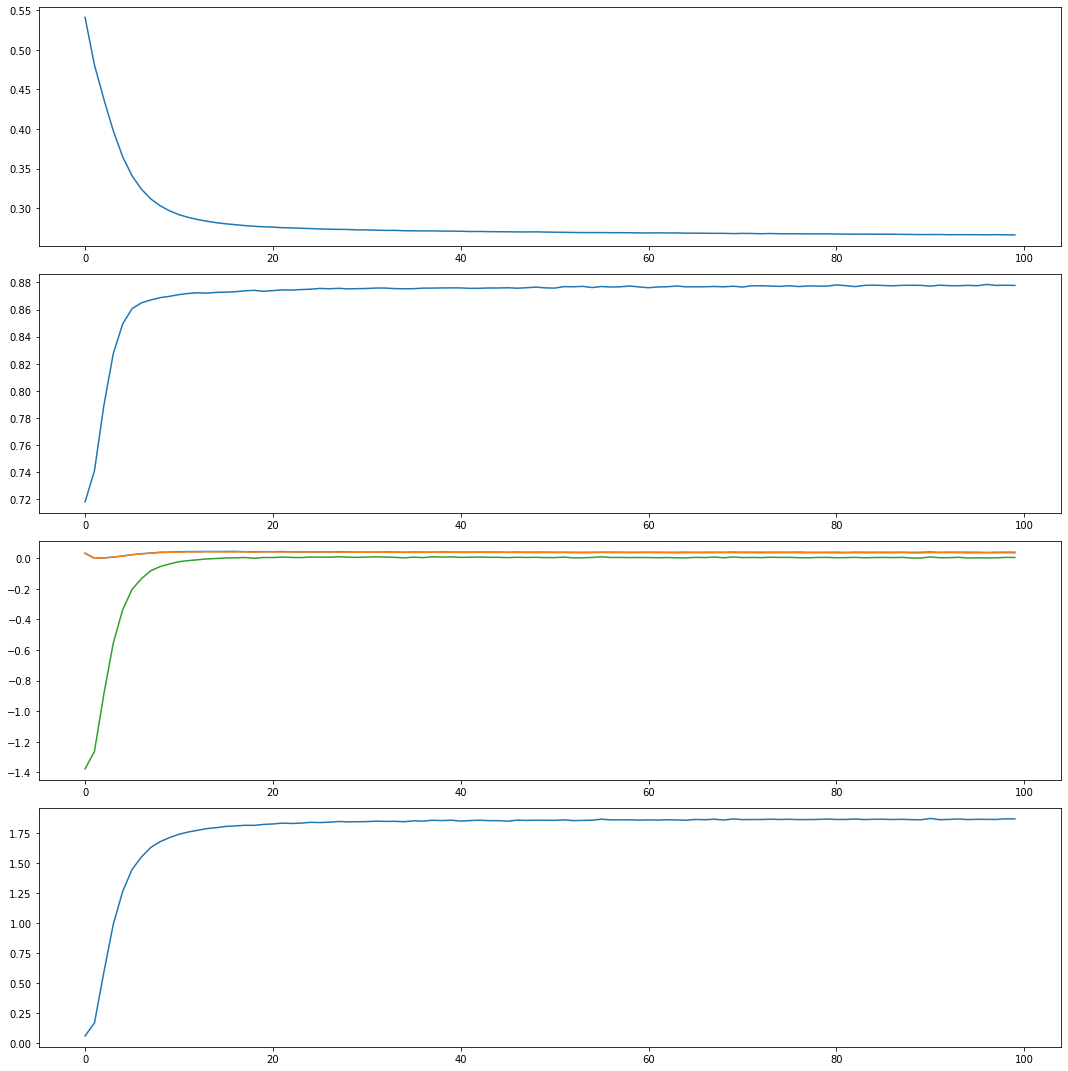

In [ ]:
import matplotlib.pyplot as plt

if not os.path.exists("supervised_model.h5"):
    fig, axs = plt.subplots(4,1, figsize = (15,10))

    axs[0].plot(history.history['loss'])
    axs[1].plot(history.history['binary_accuracy'])
    axs[2].plot(history.history['overtime'])
    axs[2].plot(history.history['overcost'])
    axs[2].plot(history.history['oversatisfaction'])
    axs[3].plot(history.history['pick_count'])
    plt.tight_layout()

### Unsupervised learning

In [ ]:
model2 = unsupervised_model(item_count = 7)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Costs (InputLayer)              [(None, 7)]          0                                            
__________________________________________________________________________________________________
Times (InputLayer)              [(None, 7)]          0                                            
__________________________________________________________________________________________________
Satisfactions (InputLayer)      [(None, 7)]          0                                            
__________________________________________________________________________________________________
Concatenate (Concatenate)       (None, 21)           0           Costs[0][0]                      
                                                                 Times[0][0]                

In [ ]:
if not os.path.exists("unsupervised_model.h5"):
    history2 = train_knapsack(model2, train_x, train_y, test_x, test_y, epochs=500)
else:
    model.load_weights("unsupervised_model.h5")

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 52us/sample - loss: 3.6612 - binary_accuracy: 0.7054 - overcost: 0.1589 - overtime: 0.1942 - oversatisfaction: -1.2762 - pick_count: 0.2450
Epoch 2/500
10000/10000 [==============================] - 0s 41us/sample - loss: -0.0923 - binary_accuracy: 0.7199 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.4188 - pick_count: 0.0000e+00
Epoch 3/500
10000/10000 [==============================] - 0s 41us/sample - loss: -0.1918 - binary_accuracy: 0.7199 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.4179 - pick_count: 0.0000e+00
Epoch 4/500
10000/10000 [==============================] - 0s 40us/sample - loss: -0.4600 - binary_accuracy: 0.7200 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.4173 - pick_count: 0.0012
Epoch 5/500
10000/10000 [==============================] - 0s 41us/sample - loss: -0.5628 - binary_accuracy: 0.7215 - overcost: 0.0000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
df_hist2 = pd.DataFrame(history2.history)
df_hist2.to_csv('history_academic_unsupervised.csv')
df_hist2.head()


,loss,binary_accuracy,overcost,overtime,oversatisfaction,pick_count
0,3.661245,0.705443,0.158869,0.194217,-1.276200,0.245008
1,-0.092297,0.719928,0.000000,0.000000,-1.418757,0.000000
2,-0.191799,0.719929,0.000000,0.000000,-1.417852,0.000000
3,-0.460033,0.720014,0.000000,0.000000,-1.417295,0.001198
4,-0.562758,0.721500,0.000000,0.000000,-1.400371,0.022165


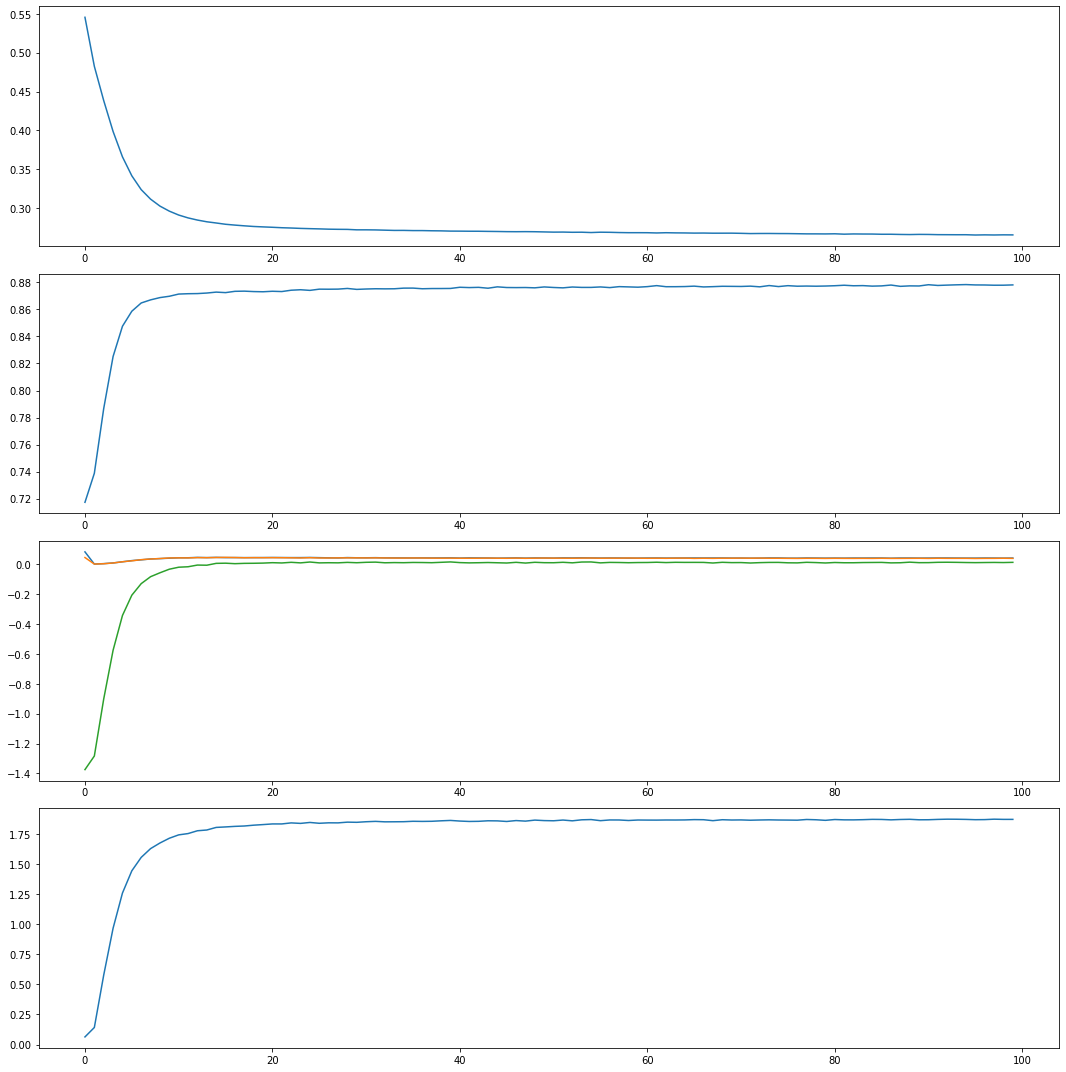

In [ ]:
fig, axs = plt.subplots(4,1, figsize = (15,15))

if not os.path.exists("unsupervised_model.h5"):
    axs[0].plot(history2.history['loss'])
    axs[1].plot(history2.history['binary_accuracy'])
    axs[2].plot(history2.history['overtime'])
    axs[2].plot(history2.history['overcost'])
    axs[2].plot(history2.history['oversatisfaction'])
    axs[3].plot(history2.history['pick_count'])
    plt.tight_layout()

## Structure

In [ ]:
# names of places to visit
places = ['A', 'B', 'C', 'D', 'E','F','G']

# distances in an upper triangular matrix
dists = [[5, 17, 20, 25, 1, 10],
         [10, 15, 19, 30, 15],
         [1, 8, 19, 7],
         [5, 20, 12],
         [10, 15],
         [13],
         []]

# tourist wants to visit all places maximizing his satisfaction, while satisfying his budget
parameters_problem ={
                    # level of preference (satisfaction) of each touristic place (maybe taken from previous tourist with similar profile?)
                    'preference_attraction': [ 1.,  2.,  5., 10.,  0.,  3.,  5.], #[10, 13, 18, 31, 7, 15, 20],
                    # cost of visiting each place 
                    'cost_attraction': [11, 15, 20, 35, 10, 33, 0],
                    # time (recommended) to visit each place
                    'time_attraction': [1.1, 1.5, 2.0, 3.5, 1.0, 3.3, 1],
                    # type of attraction (0-cultural, 1-nature)
                    'type_of_attraction': [0, 0, 0, 0, 0, 0, 1]
}

# number of nodes and list of vertices
n, V = len(dists), set(range(len(dists)))

# distances matrix
c = [[0 if i == j
      else dists[i][j-i-1] if j > i
      else dists[j][i-j-1]
      for j in V] for i in V]

## Optimize the route, eliminating places which are not of interest and satisfy budget and time available

In [ ]:
model = supervised_model(item_count = 7)
model.load_weights('/content/drive/MyDrive/Tesis/Caso Academico/supervised_model.h5')

model2 = unsupervised_model(item_count = 7)
model2.load_weights('/content/drive/MyDrive/Tesis/Caso Academico/unsupervised_model.h5')


### No constraint on time, budget or kind of route - the result should be all the touristic points selected

In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':np.inf,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places preferred (minimum) number of places to visit
                    'num_places': 0
}

In [ ]:
x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]

ypred_supervised = np.round(model.predict(x)).reshape(-1,)
print('Supervised model')
print(ypred_supervised)

ypred_unsupervised = np.round(model2.predict(x)).reshape(-1,)
print('Unsupervised model')
print(ypred_unsupervised)

Supervised model
[1. 1. 1. 1. 1. 1. 1.]
Unsupervised model
[1. 1. 1. 1. 1. 1. 1.]


In [ ]:
print('Supervised')
print('Satisfaction', sum(ypred_supervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_supervised*parameters_problem['cost_attraction']))
print('Time',sum(ypred_supervised*parameters_problem['time_attraction']))

print('Unsupervised')
print('Satisfaction', sum(ypred_unsupervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_unsupervised*parameters_problem['cost_attraction']))
print('Time', sum(ypred_unsupervised*parameters_problem['time_attraction']))

Supervised
Satisfaction 26.0
Cost 124.0
Time 13.399999999999999
Unsupervised
Satisfaction 26.0
Cost 124.0
Time 13.399999999999999


### Constrain the budget

In [ ]:
# NO HEURISTICS
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]

ypred_supervised = np.round(model.predict(x)).reshape(-1,)
print('Supervised model')
print(ypred_supervised)

ypred_unsupervised = np.round(model2.predict(x)).reshape(-1,)
print('Unsupervised model')
print(ypred_unsupervised)

Supervised model
[1. 1. 1. 1. 1. 1. 1.]
Unsupervised model
[1. 1. 1. 1. 0. 1. 1.]


In [ ]:
print('Supervised')
print('Satisfaction', sum(ypred_supervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_supervised*parameters_problem['cost_attraction']))
print('Time',sum(ypred_supervised*parameters_problem['time_attraction']))

print('Unsupervised')
print('Satisfaction', sum(ypred_unsupervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_unsupervised*parameters_problem['cost_attraction']))
print('Time', sum(ypred_unsupervised*parameters_problem['time_attraction']))

Supervised
Satisfaction 26.0
Cost 124.0
Time 13.399999999999999
Unsupervised
Satisfaction 26.0
Cost 114.0
Time 12.399999999999999


In [ ]:
from tqdm import tqdm
import time

exec_time_ann_supervised = []
for i in tqdm(range(100)):
    start = time.time()
    np.round(model.predict(x))
    end = time.time()
    exec_time_ann_supervised.append(end-start)

exec_time_ann_unsupervised = []
for i in tqdm(range(100)):
    start = time.time()
    np.round(model2.predict(x))
    end = time.time()
    exec_time_ann_unsupervised.append(end-start)

100%|██████████| 100/100 [00:00<00:00, 864.08it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


       ann_supervised  ann_unsupervised
count      100.000000        100.000000
mean         0.001192          0.001143
std          0.000291          0.000229
min          0.000981          0.000973
25%          0.001068          0.001059
50%          0.001117          0.001089
75%          0.001179          0.001125
max          0.002951          0.002311


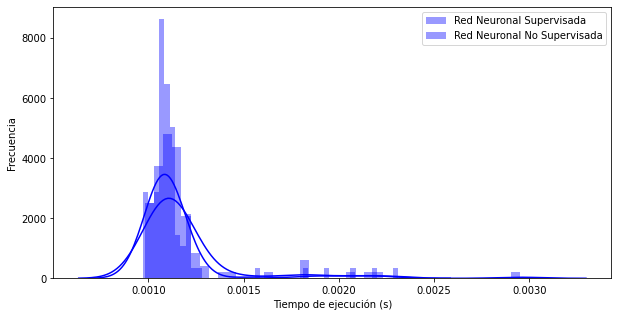

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'ann_supervised': exec_time_ann_supervised, 'ann_unsupervised': exec_time_ann_unsupervised})
 
# Method 1: on the same Axis
plt.figure(figsize=(10,5))
sns.distplot( df["ann_supervised"] , color="blue", label="Red Neuronal Supervisada")
sns.distplot( df["ann_unsupervised"] , color="blue", label="Red Neuronal No Supervisada")
plt.legend()
plt.xlabel('Tiempo de ejecución (s)')
plt.ylabel('Frecuencia')

print(df.describe())


### All constraints except preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]

ypred_supervised = np.round(model.predict(x)).reshape(-1,)
print('Supervised model')
print(ypred_supervised)

ypred_unsupervised = np.round(model2.predict(x)).reshape(-1,)
print('Unsupervised model')
print(ypred_unsupervised)

Supervised model
[1. 1. 1. 1. 0. 0. 1.]
Unsupervised model
[0. 0. 0. 1. 0. 0. 1.]


In [ ]:
print('Supervised')
print('Satisfaction', sum(ypred_supervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_supervised*parameters_problem['cost_attraction']))
print('Time',sum(ypred_supervised*parameters_problem['time_attraction']))

print('Unsupervised')
print('Satisfaction', sum(ypred_unsupervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_unsupervised*parameters_problem['cost_attraction']))
print('Time', sum(ypred_unsupervised*parameters_problem['time_attraction']))

Supervised
Satisfaction 23.0
Cost 81.0
Time 9.1
Unsupervised
Satisfaction 15.0
Cost 35.0
Time 4.5


# Case 2 - Antigua Guatemala

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Preparacion de la red neuronal

### Modo Supervisado

In [ ]:
train_x, train_y = create_knapsack_dataset(10000, item_count = 10)
test_x, test_y = create_knapsack_dataset(200, item_count = 10)

print(train_x[:5])
#print(train_x.shape)
print(train_y[:5])
print(train_y.shape)

print(test_x[:5])
#print(test_x.shape)
print(test_y[:5])
print(test_y.shape)

[array([[1.10344828, 0.24137931, 1.06896552, ..., 0.10344828, 0.4137931 ,
        1.06896552],
       [0.82608696, 0.41304348, 0.23913043, ..., 0.41304348, 0.36956522,
        0.06521739],
       [0.48648649, 0.10810811, 0.21621622, ..., 0.16216216, 0.5       ,
        0.48648649],
       ...,
       [0.09473684, 0.18947368, 0.06315789, ..., 0.02105263, 0.36842105,
        0.16842105],
       [3.25      , 1.        , 9.        , ..., 2.25      , 1.25      ,
        1.75      ],
       [0.34482759, 0.11494253, 0.40229885, ..., 0.22988506, 0.45977011,
        0.09195402]]), array([[0.05172414, 0.12068966, 0.74137931, ..., 0.01724138, 0.51724138,
        0.48275862],
       [0.3258427 , 0.49438202, 0.17977528, ..., 0.28089888, 0.33707865,
        0.49438202],
       [0.48275862, 1.31034483, 1.13793103, ..., 1.        , 1.17241379,
        1.06896552],
       ...,
       [1.22727273, 0.45454545, 1.09090909, ..., 0.59090909, 0.27272727,
        1.18181818],
       [0.61904762, 1.85714286, 0

In [ ]:
model = supervised_model(item_count = 10)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Costs (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
Times (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
Satisfactions (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
Concatenate (Concatenate)       (None, 30)           0           Costs[0][0]                      
                                                                 Times[0][0]                

In [ ]:
if not os.path.exists("supervised_model.h5"):
    history = train_knapsack(model, train_x, train_y, test_x, test_y, epochs=500)
else:
    model.load_weights("supervised_model.h5")

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 55us/sample - loss: 0.5057 - binary_accuracy: 0.7607 - overcost: 0.2121 - overtime: 0.1826 - oversatisfaction: -1.4729 - pick_count: 0.2700
Epoch 2/500
10000/10000 [==============================] - 0s 48us/sample - loss: 0.4496 - binary_accuracy: 0.7749 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.6188 - pick_count: 0.0030
Epoch 3/500
10000/10000 [==============================] - 0s 46us/sample - loss: 0.4093 - binary_accuracy: 0.7827 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.5418 - pick_count: 0.0852
Epoch 4/500
10000/10000 [==============================] - 0s 46us/sample - loss: 0.3700 - binary_accuracy: 0.8159 - overcost: 1.9795e-04 - overtime: 2.9559e-04 - oversatisfaction: -1.2017 - pick_count: 0.4639
Epoch 5/500
10000/10000 [==============================] - 0s 44us/sample - loss: 0.3366 - binary_accuracy: 0.8494 - overcost: 0.0026 - overtime:

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Model results(Train/Test):
Loss:               0.20 / 0.27
Binary accuracy:    0.91 / 0.88
Cost violation:    0.03 / 0.05
Time violation:    0.04 / 0.08
Oversatisfaction:        -0.03 / 0.01
Pick count:         2.13 / 2.49


In [ ]:
df_hist = pd.DataFrame(history.history)
df_hist.to_csv('history_guatemala_supervised.csv')

model.save('supervised_model.h5')
df_hist.head()

,loss,binary_accuracy,overcost,overtime,oversatisfaction,pick_count
0,0.505663,0.76070,0.212075,0.182634,-1.472945,0.269968
1,0.449647,0.77488,0.000000,0.000000,-1.618837,0.002995
2,0.409294,0.78273,0.000000,0.000000,-1.541831,0.085164
3,0.369991,0.81585,0.000198,0.000296,-1.201723,0.463858
4,0.336553,0.84945,0.002628,0.003072,-0.810934,0.926318


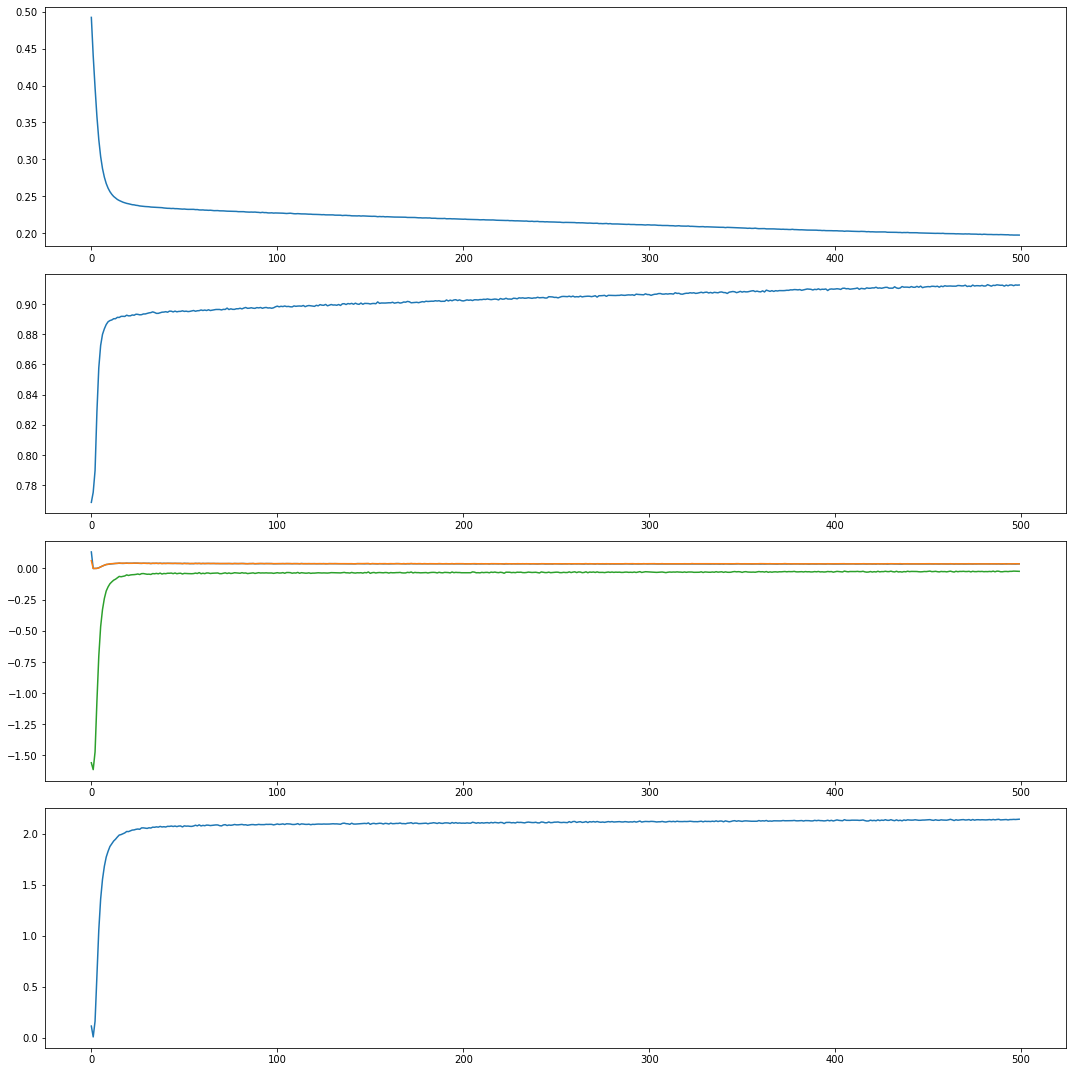

In [ ]:
import matplotlib.pyplot as plt

if not os.path.exists("supervised_model.h5"):
    fig, axs = plt.subplots(4,1, figsize = (15,15))

    axs[0].plot(history.history['loss'])
    axs[1].plot(history.history['binary_accuracy'])
    axs[2].plot(history.history['overtime'])
    axs[2].plot(history.history['overcost'])
    axs[2].plot(history.history['oversatisfaction'])
    axs[3].plot(history.history['pick_count'])
    plt.tight_layout()

### Unsupervised learning

In [ ]:
model2 = unsupervised_model(item_count = 10)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Costs (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
Times (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
Satisfactions (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
Concatenate (Concatenate)       (None, 30)           0           Costs[0][0]                      
                                                                 Times[0][0]                  

In [ ]:
if not os.path.exists("unsupervised_model.h5"):
    history2 = train_knapsack(model2, train_x, train_y, test_x, test_y, epochs=500)
else:
    model.load_weights("unsupervised_model.h5")

Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 67us/sample - loss: 2.1422 - binary_accuracy: 0.7728 - overcost: 0.0254 - overtime: 0.0567 - oversatisfaction: -1.6088 - pick_count: 0.0317
Epoch 2/500
10000/10000 [==============================] - 0s 44us/sample - loss: -0.1385 - binary_accuracy: 0.7747 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.6266 - pick_count: 0.0000e+00
Epoch 3/500
10000/10000 [==============================] - 0s 43us/sample - loss: -0.3429 - binary_accuracy: 0.7747 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.6260 - pick_count: 0.0000e+00
Epoch 4/500
10000/10000 [==============================] - 0s 43us/sample - loss: -0.5052 - binary_accuracy: 0.7747 - overcost: 0.0000e+00 - overtime: 0.0000e+00 - oversatisfaction: -1.6247 - pick_count: 0.0012
Epoch 5/500
10000/10000 [==============================] - 0s 41us/sample - loss: -0.5693 - binary_accuracy: 0.7751 - overcost: 0.0000

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
df_hist = pd.DataFrame(history2.history)
df_hist.to_csv('history_guatemala_unsupervised.csv')

model2.save('unsupervised_model.h5')

df_hist.head()

,loss,binary_accuracy,overcost,overtime,oversatisfaction,pick_count
0,2.142158,0.77279,0.025357,0.056686,-1.608842,0.031749
1,-0.138537,0.77467,0.000000,0.000000,-1.626607,0.000000
2,-0.342899,0.77467,0.000000,0.000000,-1.626021,0.000000
3,-0.505165,0.77473,0.000000,0.000000,-1.624670,0.001198
4,-0.569335,0.77505,0.000000,0.000000,-1.620221,0.007788


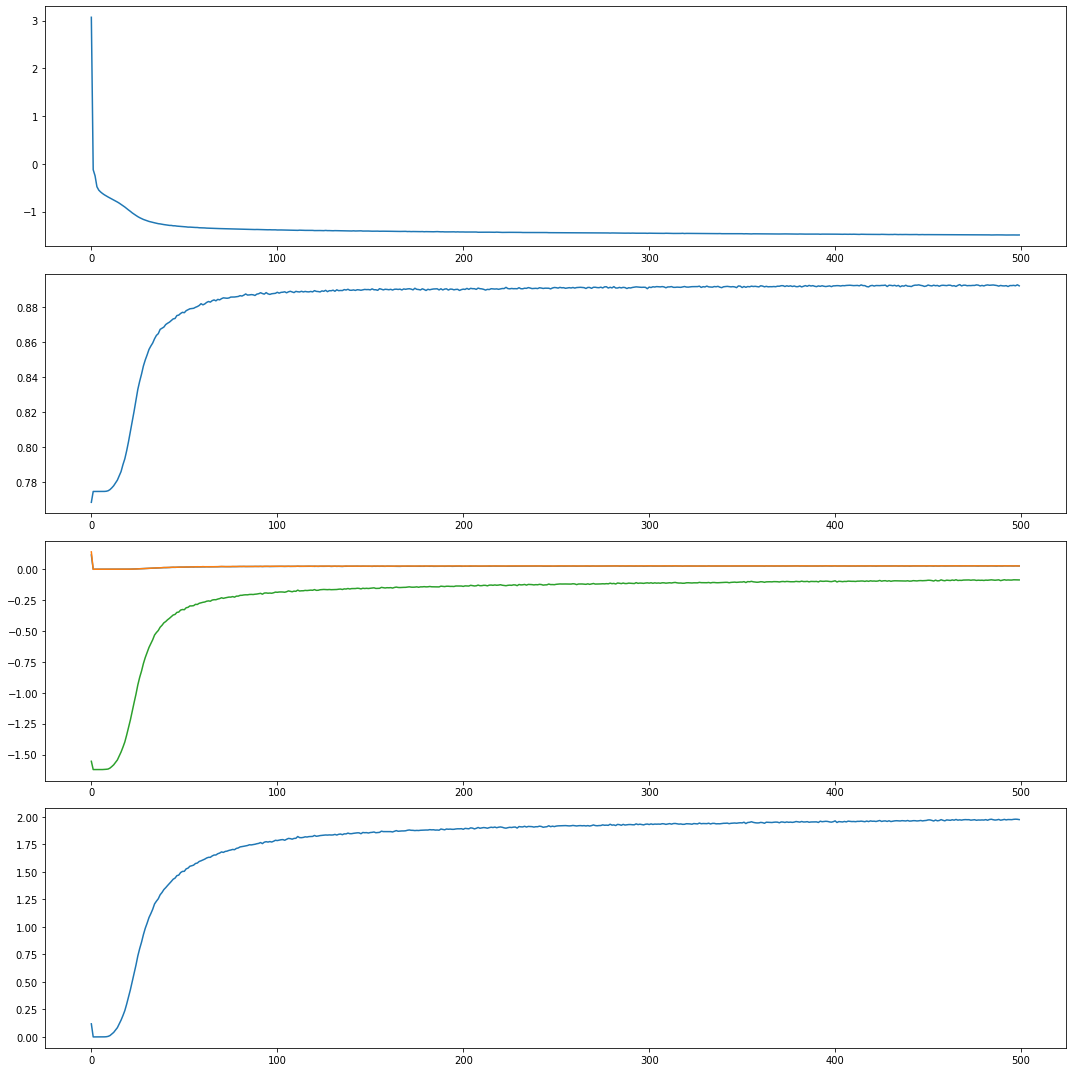

In [ ]:
fig, axs = plt.subplots(4,1, figsize = (15,15))

if not os.path.exists("unsupervised_model.h5"):
    axs[0].plot(history2.history['loss'])
    axs[1].plot(history2.history['binary_accuracy'])
    axs[2].plot(history2.history['overtime'])
    axs[2].plot(history2.history['overcost'])
    axs[2].plot(history2.history['oversatisfaction'])
    axs[3].plot(history2.history['pick_count'])
    plt.tight_layout()

## Preprocessing

In [ ]:
#wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/12mAtfRX3-2rbDS59mF2PAemRquq4b7dy5SurHRAha1A/edit#gid=1434767635')
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/12mAtfRX3-2rbDS59mF2PAemRquq4b7dy5SurHRAha1A/edit?usp=sharing')
hoja_puntos = wb.worksheet('Puntos de interes')
hoja_distancias = wb.worksheet('Distancias')
hoja_parametros = wb.worksheet('Parametros')

In [ ]:
data = hoja_puntos.get_all_values()
df_puntos = pd.DataFrame(data)

# la primera linea as header
df_puntos.columns = df_puntos.iloc[0]
df_puntos = df_puntos[1:]


df_puntos.head()

,Sitio,"Latitud, Longitud","Tipo (0-cultural, 1-natural)"
1,El Arco de Santa Catalina,"14.5599516, -90.7342724",0
2,Volcán Acatenango,"14.500461, -90.8756662",1
3,Volcán Pacaya,"14.3823075, -90.60150709999999",1
4,Mercado de Artesanias El Carmen,"14.5585534, -90.732288",0
5,Iglesia de La Merced Antigua Guatemala,"14.5612059, -90.7345734",0


In [ ]:
# Separar latitud y longitud
df_coords = df_puntos['Latitud, Longitud'].str.split(',', expand=True)
print(df_coords)
df_puntos['Latitud'] = df_coords.loc[:,0]
df_puntos['Longitud'] = df_coords.loc[:,1]

# remover coluna lat, long mezclado
df_puntos = df_puntos.drop(['Latitud, Longitud'], axis = 1)
df_puntos = df_puntos.set_index('Sitio', drop=True)
df_puntos.head()

             0                    1
1   14.5599516          -90.7342724
2    14.500461          -90.8756662
3   14.3823075   -90.60150709999999
4   14.5585534           -90.732288
5   14.5612059          -90.7345734
6   14.5568894          -90.7336838
7   14.5644444   -90.73166669999999
8   14.5535666          -90.7289438
9   32.5322103         -116.8785191
10   14.545775           -90.777204


,"Tipo (0-cultural, 1-natural)",Latitud,Longitud
Sitio,,,
El Arco de Santa Catalina,0,14.5599516,-90.7342724
Volcán Acatenango,1,14.500461,-90.8756662
Volcán Pacaya,1,14.3823075,-90.60150709999999
Mercado de Artesanias El Carmen,0,14.5585534,-90.732288
Iglesia de La Merced Antigua Guatemala,0,14.5612059,-90.7345734


In [ ]:
data = hoja_distancias.get_all_values()
df_dist = pd.DataFrame(data)

# la primera linea as header
df_dist.columns = df_dist.iloc[0]
df_dist = df_dist[1:]
df_dist = df_dist.set_index('', drop = True)

df_dist.head()

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,1 m,23.5 km,49.8 km,0.9 km,0.2 km,0.7 km,2.0 km,1.5 km,"4,113 km",7.6 km
Acatenango Volcano,22.1 km,1 m,67.8 km,22.2 km,30.8 km,22.0 km,31.3 km,#ERROR!,"4,120 km",18.8 km
Volcán Pacay,#ERROR!,67.6 km,1 m,46.6 km,47.1 km,#ERROR!,48.7 km,47.2 km,"4,165 km",58.7 km
Mercado de Artesanias El Carmen,0.8 km,23.9 km,49.4 km,1 m,0.5 km,#ERROR!,2.0 km,1.1 km,"4,113 km",7.9 km
Iglesia de La Merced Antigua Guatemala,0.4 km,23.4 km,49.7 km,0.8 km,1 m,0.5 km,1.8 km,1.4 km,"4,113 km",7.4 km


In [ ]:
# remover km en las celdas y ponder 1m como 0 (el mismo punto)
df_dist = df_dist.replace({',':'','km':'', '1 m':0, '#ERROR!':np.nan}, regex= True).astype(float)
df_dist

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,0.0,23.5,49.8,0.9,0.2,0.7,2.0,1.5,4113.0,7.6
Acatenango Volcano,22.1,0.0,67.8,22.2,30.8,22.0,31.3,NaN,4120.0,18.8
Volcán Pacay,NaN,67.6,0.0,46.6,47.1,NaN,48.7,47.2,4165.0,58.7
Mercado de Artesanias El Carmen,0.8,23.9,49.4,0.0,0.5,NaN,2.0,1.1,4113.0,7.9
Iglesia de La Merced Antigua Guatemala,0.4,23.4,49.7,0.8,0.0,0.5,1.8,1.4,4113.0,7.4
Parque Central Antigua Guatemala,0.5,23.2,49.8,0.7,0.7,0.0,2.6,0.8,4113.0,7.3
Cerro de la Cruz Antigua Guatemala,NaN,31.3,51.2,2.3,1.5,2.1,0.0,2.9,4113.0,9.0
Iglesia de san francisco Antigua Guatemala,1.3,23.3,49.2,1.0,1.5,1.2,3.0,0.0,4114.0,7.3
Granjas de Caoba,4113.0,4119.0,4163.0,4114.0,4113.0,4114.0,4114.0,4115.0,NaN,4120.0


In [ ]:
df_dist = df_dist.fillna(df_dist.mean())
df_dist

,El Arco de Santa Catalina,Volcán Acatenango,Volcán Pacaya,Mercado de Artesanias El Carmen,Iglesia de La Merced Antigua Guatemala,Parque Central Antigua Guatemala,Cerro de la Cruz Antigua Guatemala,Iglesia de San Francisco Antigua Guatemala,Granjas de Caoba,Museo Casa del Tejido
,,,,,,,,,,
El Arco de Santa Catalina,0.000,23.5,49.8,0.9,0.2,0.7000,2.0,1.500000,4113.000000,7.6
Acatenango Volcano,22.100,0.0,67.8,22.2,30.8,22.0000,31.3,464.144444,4120.000000,18.8
Volcán Pacay,518.175,67.6,0.0,46.6,47.1,518.4625,48.7,47.200000,4165.000000,58.7
Mercado de Artesanias El Carmen,0.800,23.9,49.4,0.0,0.5,518.4625,2.0,1.100000,4113.000000,7.9
Iglesia de La Merced Antigua Guatemala,0.400,23.4,49.7,0.8,0.0,0.5000,1.8,1.400000,4113.000000,7.4
Parque Central Antigua Guatemala,0.500,23.2,49.8,0.7,0.7,0.0000,2.6,0.800000,4113.000000,7.3
Cerro de la Cruz Antigua Guatemala,518.175,31.3,51.2,2.3,1.5,2.1000,0.0,2.900000,4113.000000,9.0
Iglesia de san francisco Antigua Guatemala,1.300,23.3,49.2,1.0,1.5,1.2000,3.0,0.000000,4114.000000,7.3
Granjas de Caoba,4113.000,4119.0,4163.0,4114.0,4113.0,4114.0000,4114.0,4115.000000,4120.333333,4120.0


In [ ]:
data = hoja_parametros.get_all_values()
df_parametros = pd.DataFrame(data)
df_parametros.columns = df_parametros.loc[0,:]
df_parametros = df_parametros.drop(0)
for column in ['Satisfaccion', 'Costo (USD)', 'Tiempo de visita (estimado)']:
    df_parametros[column] = df_parametros[column].astype(float)

df_parametros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 10
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Atraccion                    10 non-null     object 
 1   Satisfaccion                 10 non-null     float64
 2   Fuente (satisf)              10 non-null     object 
 3   Costo (USD)                  10 non-null     float64
 4   Costo (GTQ)                  10 non-null     object 
 5   Fuente (costo)               10 non-null     object 
 6   Tiempo de visita (estimado)  10 non-null     float64
dtypes: float64(3), object(4)
memory usage: 640.0+ bytes


## Structure

Estimar el costo
Tomamos el precio de la gasolina por litro (Guatemala) en https://es.globalpetrolprices.com
+ 0.728 USD/L

Estimaos el costo de cada atraccion por:
+ el sitio online
+ si no tiene precio en el primero, tripadvisor.es

| Atraccion |Satisfaccion| Fuente (satisf) | Costo (USD)| Fuente (costo)| Tiempo|
|----|----|-----|----|----|-----|
|El Arco de Santa Catalina|4.7|maps.google.com| 0 ||0.5|
|Acatenango Volcan|4.6|maps.google.com|80 (620GTQ) |tripadvisor.es |6|
|Volcán Pacay|4.5|maps.google.com|25.74 (200GTQ) |http://www.volcanpacaya.info/281291923|1|
|Mercado de Artesanias El Carmen|4.6|maps.google.com|0||2|
|Iglesia de La Merced Antigua Guatemala|4.7|""|0||0.5|
|Parque Central Antigua Guatemala|4.6|maps.google.com|0||1.5|
|Cerro de la Cruz Antigua Guatemala|4.6|maps.google.com|0||1|
|Iglesia de san francisco Antigua Guatemala|4.8|maps.google.com|0||0.5|
|Granjas de Caoba|4.5|maps.google.com| 8.37 (65GTQ)|www.caobafarms.com|2.3|
|Museo Casa del Tejido|4.7|maps.google.com|6.43 (50GTQ)|guatemala.com|1.5|

In [ ]:
# names of places to visit
places = df_dist.columns

# tourist wants to visit all places maximizing his satisfaction, while satisfying his budget
# preferences from google maps
# cost attraction de el sitio online de cada atracion (considera el costo aproximado de transporte)
# 0.728 USD/L de gasolina
# time_attraction es estimado
parameters_problem ={
                    # level of preference (satisfaction) of each touristic place (maybe taken from previous tourist with similar profile?)
                    'preference_attraction': df_parametros['Satisfaccion'].values,
                    # cost of visiting each place 
                    'cost_attraction': df_parametros['Costo (USD)'].values,
                    # time (recommended) to visit each place
                    'time_attraction': df_parametros['Tiempo de visita (estimado)'].values,
                    # type of attraction (0-cultural, 1-nature)
                    'type_of_attraction': df_puntos['Tipo (0-cultural, 1-natural)'].values
}

# number of nodes and list of vertices
n, V = len(places), set(range(len(places)))

# distances matrix
c = df_dist.values

In [ ]:
parameters_problem

{'cost_attraction': array([ 0.  , 80.  , 25.74,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  8.37,
         6.43]),
 'preference_attraction': array([4.7, 4.6, 4.5, 4.6, 4.7, 4.6, 4.6, 4.8, 4.5, 4.7]),
 'time_attraction': array([0.5, 6. , 1. , 2. , 0.5, 1.5, 1. , 0.5, 2.3, 1.5]),
 'type_of_attraction': array(['0', '1', '1', '0', '0', '1', '1', '0', '1', '0'], dtype=object)}

## Optimize the route, eliminating places which are not of interest and satisfy budget and time available

In [ ]:
model = supervised_model(item_count = 10)
model.load_weights('/content/drive/MyDrive/Tesis/Antigua Guatemala/supervised_model.h5')

model2 = unsupervised_model(item_count = 10)
model2.load_weights('/content/drive/MyDrive/Tesis/Antigua Guatemala/unsupervised_model.h5')


### No constraint on time, budget or kind of route - the result should be all the touristic points selected

In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':np.inf,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places preferred (minimum) number of places to visit
                    'num_places': 0
}

In [ ]:
x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]

print('Supervised model')
print(np.round(model.predict(x)))

print('Unsupervised model')
print(np.round(model2.predict(x)))

Supervised model
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Unsupervised model
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Constrain the budget

In [ ]:
# NO HEURISTICS
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':30,
                    # t_tot is the total available time of the tourist
                    'time_available':np.inf,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]

ypred_supervised = np.round(model.predict(x)).reshape(-1,)
print('Supervised model')
print(ypred_supervised)

ypred_unsupervised = np.round(model2.predict(x)).reshape(-1,)
print('Unsupervised model')
print(ypred_unsupervised)

Supervised model
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
Unsupervised model
[1. 0. 0. 1. 1. 1. 1. 1. 0. 1.]


In [ ]:
print('Supervised')
print('Satisfaction', sum(ypred_supervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_supervised*parameters_problem['cost_attraction']))
print('Time',sum(ypred_supervised*parameters_problem['time_attraction']))

print('Unsupervised')
print('Satisfaction', sum(ypred_unsupervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_unsupervised*parameters_problem['cost_attraction']))
print('Time', sum(ypred_unsupervised*parameters_problem['time_attraction']))

Supervised
Satisfaction 32.5
Cost 8.37
Time 8.3
Unsupervised
Satisfaction 32.7
Cost 6.43
Time 7.5


In [ ]:
from tqdm import tqdm
import time

exec_time_ann_supervised = []
for i in tqdm(range(100)):
    start = time.time()
    np.round(model.predict(x))
    end = time.time()
    exec_time_ann_supervised.append(end-start)

exec_time_ann_unsupervised = []
for i in tqdm(range(100)):
    start = time.time()
    np.round(model2.predict(x))
    end = time.time()
    exec_time_ann_unsupervised.append(end-start)

100%|██████████| 100/100 [00:00<00:00, 937.70it/s]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


       ann_supervised  ann_unsupervised
count      100.000000        100.000000
mean         0.001082          0.001047
std          0.000332          0.000148
min          0.000882          0.000925
25%          0.000970          0.000977
50%          0.001021          0.001012
75%          0.001080          0.001040
max          0.004071          0.001630


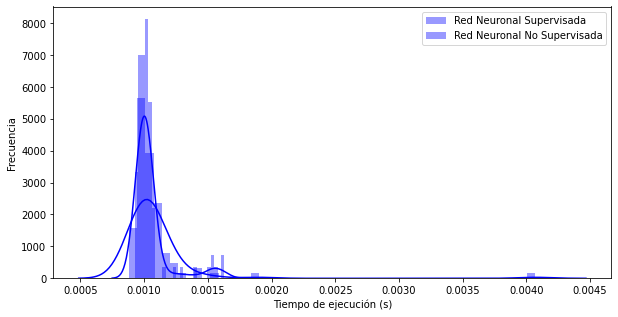

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'ann_supervised': exec_time_ann_supervised, 'ann_unsupervised': exec_time_ann_unsupervised})
 
# Method 1: on the same Axis
plt.figure(figsize=(10,5))
sns.distplot( df["ann_supervised"] , color="blue", label="Red Neuronal Supervisada")
sns.distplot( df["ann_unsupervised"] , color="blue", label="Red Neuronal No Supervisada")
plt.legend()
plt.xlabel('Tiempo de ejecución (s)')
plt.ylabel('Frecuencia')

print(df.describe())



### All constraints except preference on kind



In [ ]:
parameters_tourist = {
                    # budget is the tourist budget
                    'budget':80,
                    # t_tot is the total available time of the tourist
                    'time_available':7,
                    # pref is the preferred kind of tourism (0-cultural, 1-nature)
                    'preference': np.inf,
                    # num_places is the preferred (minimum) number of places to visit
                    'num_places': 0
}

x = [
     np.array([[ cost/parameters_tourist['budget'] for cost in parameters_problem['cost_attraction'] ]]),
     np.array([[time/parameters_tourist['time_available'] for time in parameters_problem['time_attraction'] ]]), 
     np.array( [[ pref/max(parameters_problem['preference_attraction']) for pref in parameters_problem['preference_attraction']]]) 
     ]
ypred_supervised = np.round(model.predict(x).reshape(-1,))
print('Supervised model')
print(ypred_supervised)

ypred_unsupervised = np.round(model2.predict(x).reshape(-1,))
print('Unsupervised model')
print(ypred_unsupervised)

Supervised model
[1. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
Unsupervised model
[1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]


In [ ]:
print('Supervised')
print('Satisfaction', sum(ypred_supervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_supervised*parameters_problem['cost_attraction']))
print('Time',sum(ypred_supervised*parameters_problem['time_attraction']))

print('Unsupervised')
print('Satisfaction', sum(ypred_unsupervised*parameters_problem['preference_attraction']))
print('Cost', sum(ypred_unsupervised*parameters_problem['cost_attraction']))
print('Time', sum(ypred_unsupervised*parameters_problem['time_attraction']))

Supervised
Satisfaction 27.900000000000002
Cost 8.37
Time 6.3
Unsupervised
Satisfaction 37.2
Cost 32.17
Time 8.5


In [ ]:
model2.predict(x)

array([[9.6751493e-01, 1.2657909e-05, 5.5042922e-01, 5.7119930e-01,
        9.2337960e-01, 9.6549129e-01, 9.7124618e-01, 9.9750417e-01,
        2.5401133e-01, 8.4186530e-01]], dtype=float32)